In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from cv2 import imread, resize, imwrite
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import load_img
import glob
import json
import random
from random import sample 

%matplotlib inline

In [ ]:
import urllib.request

url = "https://storage.googleapis.com/open_source_datasets/ShelfImages.tar.gz"

downloaded_filename = 'ShelfImages.tar.gz'

urllib.request.urlretrieve(url, downloaded_filename)

('ShelfImages.tar.gz', <http.client.HTTPMessage at 0x7f0328511610>)

In [ ]:
import tarfile

fname = downloaded_filename

if fname.endswith("tar.gz"):

    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [ ]:
from zipfile import ZipFile
ZipFile("/content/grocerydataset-master.zip").extractall()

In [ ]:
IM_EXTENSIONS = ['png', 'jpg', 'bmp']

def load_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data

def get_best_anchor(anchors, box_wh):
    box_wh = np.array(box_wh)
    best_iou = 0
    best_anchor = 0
    for k, anchor in enumerate(anchors):
        intersect_wh = np.maximum(np.minimum(box_wh, anchor), 0.0)
        intersect_area = intersect_wh[0] * intersect_wh[1]
        box_area = box_wh[0] * box_wh[1]
        anchor_area = anchor[0] * anchor[1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)
        if iou > best_iou:
            best_iou = iou
            best_anchor = k
    return best_anchor

In [ ]:
def update_bbox(img_path, bboxes, shape):
    img = load_img(img_path)
    w, h = img.size
    new_bbox = []
    for bbox in bboxes:
        x1, x2 = bbox[0], bbox[0]+bbox[2]
        y1, y2 = bbox[1], bbox[1]+bbox[3]
        new_bbox.append([x1, y1, x2, y2])
    return new_bbox, (w, h)


ROOT_PATH = "/content"
ROOT_TRAIN_PATH = os.path.join(ROOT_PATH, "ShelfImages", "train")
ROOT_TEST_PATH = os.path.join(ROOT_PATH, "ShelfImages", "test")
TRAIN_ANNOTATIAONS = []
TEST_ANNOTATIONS = []
with open(os.path.join(ROOT_PATH, "grocerydataset", "annotation.txt")) as f:
    for line in f.readlines():
        a = line.split()
        bboxes = []
        for i in range(int(a[1])):
            bboxes.append([int(j) for j in a[i*5 + 2: i*5+6]])
        img = {}
        if os.path.exists(os.path.join(ROOT_TRAIN_PATH, a[0])):
            img['filename'] = os.path.join(ROOT_TRAIN_PATH, a[0])
            bb, shape = update_bbox(os.path.join(ROOT_TRAIN_PATH, a[0]), bboxes, (416, 416))
            img['width'] = shape[0]
            img['height'] = shape[1]
            img['object'] = []
            for b in bb:
                obj = {}
                obj['name'] = "pack"
                obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'] = b
                img['object'] += [obj]
                
            TRAIN_ANNOTATIAONS += [img]
        if os.path.exists(os.path.join(ROOT_TEST_PATH, a[0])):
            img['filename'] = os.path.join(ROOT_TEST_PATH, a[0])
            bb, shape = update_bbox(os.path.join(ROOT_TEST_PATH, a[0]), bboxes, (416, 416))
            img['width'] = shape[0]
            img['height'] = shape[1]
            img['object'] = []
            for b in bb:
                obj = {}
                obj['name'] = "pack"
                obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'] = b
                img['object'] += [obj]
            
            TEST_ANNOTATIONS += [img]

In [ ]:
def iou(b1, b2):
    l1, l2 = b1[0] - int(0.5 * b1[2]), b2[0] - int(0.5 * b2[2])
    u1, u2 = l1 + b1[2] - 1, l2 + b2[2] - 1
    intersection_w = max(0, min(u1, u2) - max(l1, l2) + 1)
    if intersection_w == 0:
        return 0
    l1, l2 = b1[1] - int(0.5 * b1[3]), b2[1] - int(0.5 * b2[3])
    u1, u2 = l1 + b1[3] - 1, l2 + b2[3] - 1
    intersection_h = max(0, min(u1, u2) - max(l1, l2) + 1)
    intersection = intersection_w * intersection_h
    if intersection == 0:
        return 0

    union = b1[2] * b1[3] + b2[2] * b2[3] - intersection
    if union == 0:
        raise ValueError('Union value must not be a zero or negative number. (boxes: {}, {})'.format(b1, b2))

    return intersection / union

def kmeans_iou(boxes, k, n_iter=10):
    n_boxes = len(boxes)
    if k > n_boxes:
        raise ValueError('k({}) must be less than or equal to the number of boxes({}).'.format(k, n_boxes))

    # Update clusters and centroids alternately.
    centroids = boxes[np.random.choice(n_boxes, k, replace=False)]
    for _ in range(n_iter):
        cluster_indices = np.array([np.argmax([iou(b, c) for c in centroids]) for b in boxes])
        for i in range(k):
            if np.count_nonzero(cluster_indices == i) == 0:
                print(i)
        centroids = [np.mean(boxes[cluster_indices == i], axis=0) for i in range(k)]

    return np.array(centroids)

boxes = []
for annots in TRAIN_ANNOTATIAONS:
    for obj in annots['object']:
        x_min, x_max, y_min, y_max = obj['xmin'], obj['xmax'], obj['ymin'], obj['ymax']
        center_x, center_y = (x_max + x_min) * 0.5, (y_max + y_min) * 0.5
        width, height = x_max - x_min + 1, y_max - y_min + 1
        boxes.append([center_x, center_y, width, height])

        
boxes = np.array(boxes, dtype=np.float32)
anchors = kmeans_iou(boxes, 1, 10)[:, 2:]
print(anchors)

[[202.21478 309.0017 ]]


In [ ]:
def read_data(annotations, image_size, pixels_per_grid=32, no_label=False):
    class_map = {0:'pack'}
    num_classes = 1 #len(class_map)
    grid_h, grid_w = [image_size[i] // pixels_per_grid for i in range(2)]
    images = []
    labels = []

    for annotes in annotations:
        im_path = annotes['filename']
        # load image and resize image
        im = imread(im_path)
        im = np.array(im, dtype=np.float32)
        im_origina_sizes = im.shape[:2]
        im = resize(im, (image_size[1], image_size[0]))
        if len(im.shape) == 2:
            im = np.expand_dims(im, 2)
            im = np.concatenate([im, im, im], -1)
        images.append(im)

        if no_label:
            labels.append(0)
            continue
        label = np.zeros((grid_h, grid_w, len(anchors), 5 + num_classes))
        for obj in annotes['object']:
            x_min, x_max, y_min, y_max = obj['xmin'], obj['xmax'], obj['ymin'], obj['ymax']
            oh, ow = im_origina_sizes
            
            x_min, y_min, x_max, y_max = x_min / ow, y_min / oh, x_max / ow, y_max / oh
            x_min, y_min, x_max, y_max = np.clip([x_min, y_min, x_max, y_max], 0, 1)
            
            anchor_boxes = np.array(anchors) / np.array([ow, oh])
            best_anchor = get_best_anchor(
                anchor_boxes, [x_max - x_min, y_max - y_min])
            cx = int(np.floor(0.5 * (x_min + x_max) * grid_w))
            cy = int(np.floor(0.5 * (y_min + y_max) * grid_h))
            label[cy, cx, best_anchor, 0:4] = [x_min, y_min, x_max, y_max]
            label[cy, cx, best_anchor, 4] = 1.0
            label[cy, cx, best_anchor, 5] = 1.0
        labels.append(label)

    X_set = np.array(images, dtype=np.float32)
    y_set = np.array(labels, dtype=np.float32)

    return X_set, y_set

In [ ]:
IM_SIZE = (416, 416)
NUM_CLASSES = 1
VALID_RATIO = 0.1
X_train, y_train = read_data(TRAIN_ANNOTATIAONS, IM_SIZE)

In [ ]:
X_test, y_test = read_data(TEST_ANNOTATIONS, IM_SIZE)

In [ ]:
class DataSet(object):

    def __init__(self, images, labels=None):
        if labels is not None:
            assert images.shape[0] == labels.shape[0],\
                ('Number of examples mismatch, between images and labels')
        self._num_examples = images.shape[0]
        self._images = images
        self._labels = labels  # NOTE: this can be None, if not given.
        # image/label indices(can be permuted)
        self._indices = np.arange(self._num_examples, dtype=np.uint)
        self._reset()

    def _reset(self):
        """Reset some variables."""
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    def sample_batch(self, batch_size, shuffle=True):
        if shuffle:
            indices = np.random.choice(self._num_examples, batch_size)
        else:
            indices = np.arange(batch_size)
        batch_images = self._images[indices]
        if self._labels is not None:
            batch_labels = self._labels[indices]
        else:
            batch_labels = None
        return batch_images, batch_labels

    def next_batch(self, batch_size, shuffle=True):
        start_index = self._index_in_epoch

        # Shuffle the dataset, for the first epoch
        if self._epochs_completed == 0 and start_index == 0 and shuffle:
            np.random.shuffle(self._indices)

        # Go to the next epoch, if current index goes beyond the total number
        # of examples
        if start_index + batch_size > self._num_examples:
            # Increment the number of epochs completed
            self._epochs_completed += 1
            # Get the rest examples in this epoch
            rest_num_examples = self._num_examples - start_index
            indices_rest_part = self._indices[start_index:self._num_examples]

            # Shuffle the dataset, after finishing a single epoch
            if shuffle:
                np.random.shuffle(self._indices)

            # Start the next epoch
            start_index = 0
            self._index_in_epoch = batch_size - rest_num_examples
            end_index = self._index_in_epoch
            indices_new_part = self._indices[start_index:end_index]

            images_rest_part = self._images[indices_rest_part]
            images_new_part = self._images[indices_new_part]
            batch_images = np.concatenate(
                (images_rest_part, images_new_part), axis=0)
            if self._labels is not None:
                labels_rest_part = self._labels[indices_rest_part]
                labels_new_part = self._labels[indices_new_part]
                batch_labels = np.concatenate(
                    (labels_rest_part, labels_new_part), axis=0)
            else:
                batch_labels = None
        else:
            self._index_in_epoch += batch_size
            end_index = self._index_in_epoch
            indices = self._indices[start_index:end_index]
            batch_images = self._images[indices]
            if self._labels is not None:
                batch_labels = self._labels[indices]
            else:
                batch_labels = None

        return batch_images, batch_labels

In [ ]:
train_set = DataSet(X_train, y_train)
test_set = DataSet(X_test, y_test)

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
def conv_layer(x, filters, kernel_size, strides, padding='SAME', use_bias=True, **kwargs):
    weights_stddev = kwargs.pop('weights_stddev', 0.01)
    return tf.layers.conv2d(
        x,            
        filters,
        kernel_size, 
        strides, 
        padding, 
        kernel_initializer=tf.random_normal_initializer(stddev=weights_stddev), 
        use_bias=use_bias
    )

def batchNormalization(x, is_train):
    return tf.layers.batch_normalization(
        x, 
        training=is_train, 
        momentum=0.99, 
        epsilon=0.001, 
        center=True, 
        scale=True
    )

def conv_bn_relu(x, filters, kernel_size, is_train, strides=(1, 1), padding='SAME', relu=True):
    conv = conv_layer(x, filters, kernel_size, strides, padding, use_bias=False)
    bn = batchNormalization(conv, is_train)
    if relu:
        return tf.nn.leaky_relu(bn, alpha=0.1)
    else:
        return bn

def max_pool(x, side_l, stride, padding='SAME'):
    return tf.nn.max_pool(x, ksize=[1, side_l, side_l, 1],
                          strides=[1, stride, stride, 1], padding=padding)


In [ ]:
input_shape = list(IM_SIZE) + [3]
num_classes = NUM_CLASSES
grid_size = [x // 32 for x in input_shape[:2]]
num_anchors = len(anchors)

# Prepare Input
X = tf.placeholder(tf.float32, [None] + input_shape)
y = tf.placeholder(tf.float32, [None] + grid_size + [num_anchors] + [5 + num_classes])
is_train = tf.placeholder(tf.bool)

In [ ]:
# init build graph
graph = tf.get_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [ ]:
d = dict()

#conv1 - batch_norm1 - leaky_relu1 - pool1
with tf.variable_scope('layer1'):
    d['conv1'] = conv_bn_relu(X, 32, (3, 3), is_train)
    d['pool1'] = max_pool(d['conv1'], 2, 2, padding='SAME')
# (416, 416, 3) --> (208, 208, 32)

#conv2 - batch_norm2 - leaky_relu2 - pool2
with tf.variable_scope('layer2'):
    d['conv2'] = conv_bn_relu(d['pool1'], 64, (3, 3), is_train)
    d['pool2'] = max_pool(d['conv2'], 2, 2, padding='SAME')
# (208, 208, 32) --> (104, 104, 64)

#conv3 - batch_norm3 - leaky_relu3
with tf.variable_scope('layer3'):
    d['conv3'] = conv_bn_relu(d['pool2'], 128, (3, 3), is_train)
# (104, 104, 64) --> (104, 104, 128)

#conv4 - batch_norm4 - leaky_relu4
with tf.variable_scope('layer4'):
    d['conv4'] = conv_bn_relu(d['conv3'], 64, (1, 1), is_train)
# (104, 104, 128) --> (104, 104, 64)

#conv5 - batch_norm5 - leaky_relu5 - pool5
with tf.variable_scope('layer5'):
    d['conv5'] = conv_bn_relu(d['conv4'], 128, (3, 3), is_train)
    d['pool5'] = max_pool(d['conv5'], 2, 2, padding='SAME')
# (104, 104, 64) --> (52, 52, 128)

#conv6 - batch_norm6 - leaky_relu6
with tf.variable_scope('layer6'):
    d['conv6'] = conv_bn_relu(d['pool5'], 256, (3, 3), is_train)
# (52, 52, 128) --> (52, 52, 256)

#conv7 - batch_norm7 - leaky_relu7
with tf.variable_scope('layer7'):
    d['conv7'] = conv_bn_relu(d['conv6'], 128, (1, 1), is_train)
# (52, 52, 256) --> (52, 52, 128)

#conv8 - batch_norm8 - leaky_relu8 - pool8
with tf.variable_scope('layer8'):
    d['conv8'] = conv_bn_relu(d['conv7'], 256, (3, 3), is_train)
    d['pool8'] = max_pool(d['conv8'], 2, 2, padding='SAME')
# (52, 52, 128) --> (26, 26, 256)

#conv9 - batch_norm9 - leaky_relu9
with tf.variable_scope('layer9'):
    d['conv9'] = conv_bn_relu(d['pool8'], 512, (3, 3), is_train)
# (26, 26, 256) --> (26, 26, 512)

#conv10 - batch_norm10 - leaky_relu10
with tf.variable_scope('layer10'):
    d['conv10'] = conv_bn_relu(d['conv9'], 256, (1, 1), is_train)
# (26, 26, 512) --> (26, 26, 256)

#conv11 - batch_norm11 - leaky_relu11
with tf.variable_scope('layer11'):
    d['conv11'] = conv_bn_relu(d['conv10'], 512, (3, 3), is_train)
# (26, 26, 256) --> (26, 26, 512)

#conv12 - batch_norm12 - leaky_relu12
with tf.variable_scope('layer12'):
    d['conv12'] = conv_bn_relu(d['conv11'], 256, (1, 1), is_train)
# (26, 26, 512) --> (26, 26, 256)

#conv13 - batch_norm13 - leaky_relu13 - pool13
with tf.variable_scope('layer13'):
    d['conv13'] = conv_bn_relu(d['conv12'], 512, (3, 3), is_train)
    d['pool13'] = max_pool(d['conv13'], 2, 2, padding='SAME')
# (26, 26, 256) --> (13, 13, 512)

#conv14 - batch_norm14 - leaky_relu14
with tf.variable_scope('layer14'):
    d['conv14'] = conv_bn_relu(d['pool13'], 1024, (3, 3), is_train)
# (13, 13, 512) --> (13, 13, 1024)

#conv15 - batch_norm15 - leaky_relu15
with tf.variable_scope('layer15'):
    d['conv15'] = conv_bn_relu(d['conv14'], 512, (1, 1), is_train)
# (13, 13, 1024) --> (13, 13, 512)

#conv16 - batch_norm16 - leaky_relu16
with tf.variable_scope('layer16'):
    d['conv16'] = conv_bn_relu(d['conv15'], 1024, (3, 3), is_train)
# (13, 13, 512) --> (13, 13, 1024)

#conv17 - batch_norm16 - leaky_relu17
with tf.variable_scope('layer17'):
    d['conv17'] = conv_bn_relu(d['conv16'], 512, (1, 1), is_train)
# (13, 13, 1024) --> (13, 13, 512)

#conv18 - batch_norm18 - leaky_relu18
with tf.variable_scope('layer18'):
    d['conv18'] = conv_bn_relu(d['conv17'], 1024, (3, 3), is_train)
# (13, 13, 512) --> (13, 13, 1024)

#conv19 - batch_norm19 - leaky_relu19
with tf.variable_scope('layer19'):
    d['conv19'] = conv_bn_relu(d['conv18'], 1024, (3, 3), is_train)
# (13, 13, 1024) --> (13, 13, 1024)

#Detection Layer
#conv20 - batch_norm20 - leaky_relu20
with tf.variable_scope('layer20'):
    d['conv20'] = conv_bn_relu(d['conv19'], 1024, (3, 3), is_train)
# (13, 13, 1024) --> (13, 13, 1024)

# concatenate layer20 and layer 13 using space to depth
with tf.variable_scope('layer21'):
    d['skip_connection'] = conv_bn_relu(d['conv13'], 64, (1, 1), is_train)
    d['skip_space_to_depth_x2'] = tf.space_to_depth(
        d['skip_connection'], block_size=2)
    d['concat21'] = tf.concat(
        [d['skip_space_to_depth_x2'], d['conv20']], axis=-1)
# (13, 13, 1024) --> (13, 13, 256+1024)

#conv22 - batch_norm22 - leaky_relu22
with tf.variable_scope('layer22'):
    d['conv22'] = conv_bn_relu(d['concat21'], 1024, (3, 3), is_train)
# (13, 13, 1280) --> (13, 13, 1024)

with tf.variable_scope('output_layer'):
    output_channel = num_anchors * (5 + num_classes)
    d['logits'] = conv_layer(d['conv22'], output_channel, (1, 1), (1, 1),
                            padding='SAME', use_bias=True)
    d['pred'] = tf.reshape(
        d['logits'], (-1, grid_size[0], grid_size[1], num_anchors, 5 + num_classes))
# (13, 13, 1024) --> (13, 13, num_anchors , (5 + num_classes))

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:536: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:424: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  '`tf.layers.batch_normalization` is deprecated and '


In [ ]:
logits = d['logits']
pred = d['pred']

In [ ]:
loss_weights = [5, 5, 5, 0.5, 1.0]

grid_h, grid_w = grid_size
grid_wh = np.reshape([grid_w, grid_h], [1, 1, 1, 1, 2]).astype(np.float32)
cxcy = np.transpose([np.tile(np.arange(grid_w), grid_h), 
                     np.repeat(np.arange(grid_h), grid_h)])
cxcy = np.reshape(cxcy, (1, grid_h, grid_w, 1, 2))

txty, twth = pred[..., 0:2], pred[..., 2:4]
confidence = tf.sigmoid(pred[..., 4:5])
class_probs = tf.nn.softmax(pred[..., 5:], axis=-1)\
            if num_classes > 1 else tf.sigmoid(pred[..., 5:])
bxby = tf.sigmoid(txty) + cxcy
pwph = np.reshape(anchors, (1, 1, 1, num_anchors, 2)) / 32
bwbh = tf.exp(twth) * pwph

# calculating for prediction
nxny, nwnh = bxby / grid_wh, bwbh / grid_wh
nx1ny1, nx2ny2 = nxny - 0.5 * nwnh, nxny + 0.5 * nwnh
pred_y = tf.concat((nx1ny1, nx2ny2, confidence, class_probs), axis=-1)

# calculating IoU for metric
num_objects = tf.reduce_sum(y[..., 4:5], axis=[1, 2, 3, 4])
max_nx1ny1 = tf.maximum(y[..., 0:2], nx1ny1)
min_nx2ny2 = tf.minimum(y[..., 2:4], nx2ny2)
intersect_wh = tf.maximum(min_nx2ny2 - max_nx1ny1, 0.0)
intersect_area = tf.reduce_prod(intersect_wh, axis=-1)
intersect_area = tf.where(
    tf.equal(intersect_area, 0.0), tf.zeros_like(intersect_area), intersect_area)
gt_box_area = tf.reduce_prod(y[..., 2:4] - y[..., 0:2], axis=-1)
box_area = tf.reduce_prod(nx2ny2 - nx1ny1, axis=-1)
iou = tf.truediv(intersect_area, (gt_box_area + box_area - intersect_area))

gt_bxby = 0.5 * (y[..., 0:2] + y[..., 2:4]) * grid_wh
gt_bwbh = (y[..., 2:4] - y[..., 0:2]) * grid_wh

resp_mask = y[..., 4:5]
no_resp_mask = 1.0 - resp_mask
#gt_confidence = resp_mask * tf.expand_dims(iou, axis=-1)
gt_confidence = resp_mask
gt_class_probs = y[..., 5:]

loss_bxby = loss_weights[0] * resp_mask * tf.square(gt_bxby - bxby)
loss_bwbh = loss_weights[1] * resp_mask * tf.square(tf.sqrt(gt_bwbh) - tf.sqrt(bwbh))
loss_resp_conf = loss_weights[2] * resp_mask * tf.square(gt_confidence - confidence)
loss_no_resp_conf = loss_weights[3] * no_resp_mask * tf.square(gt_confidence - confidence)
loss_class_probs = loss_weights[4] * resp_mask * tf.square(gt_class_probs - class_probs)

merged_loss = tf.concat((
                        loss_bxby,
                        loss_bwbh,
                        loss_resp_conf,
                        loss_no_resp_conf,
                        loss_class_probs
                        ),
                        axis=-1)
total_loss = tf.reduce_sum(merged_loss, axis=-1)
total_loss = tf.reduce_mean(total_loss)

In [ ]:
def nms(boxes, conf_thres=0.2, iou_thres=0.5):
    x1 = boxes[..., 0]
    y1 = boxes[..., 1]
    x2 = boxes[..., 2]
    y2 = boxes[..., 3]
    areas = (x2 - x1) * (y2 - y1)
    scores = boxes[..., 4]

    keep = []
    order = scores.argsort()[::-1]

    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= iou_thres)[0]
        order = order[inds + 1]

    nms_box = []
    for idx in range(len(boxes)):
        if idx in keep and boxes[idx, 4] > conf_thres:
            nms_box.append(boxes[idx])
        else:
            nms_box.append(np.zeros(boxes.shape[-1]))
    boxes = np.array(nms_box)
    return boxes

def convert_boxes(input_y):
    is_batch = len(input_y.shape) == 5
    if not is_batch:
        input_y = np.expand_dims(input_y, 0)
    boxes = np.reshape(input_y, (input_y.shape[0], -1, input_y.shape[-1]))
    if is_batch:
        return np.array(boxes)
    else:
        return boxes[0]

def predict_nms_boxes(input_y, conf_thres=0.2, iou_thres=0.5):
    is_batch = len(input_y.shape) == 5
    if not is_batch:
        input_y = np.expand_dims(input_y, 0)
    boxes = np.reshape(input_y, (input_y.shape[0], -1, input_y.shape[-1]))
    nms_boxes = []
    for box in boxes:
        nms_box = nms(box, conf_thres, iou_thres)
        nms_boxes.append(nms_box)
    if is_batch:
        return np.array(nms_boxes)
    else:
        return nms_boxes[0]

def cal_map(gt_bboxes, bboxes,thresholds=[0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]):
    m_tot = 0.0
    for iou_thres in thresholds:
        p = 0
        tp = 0
        fn = 0
        fp = 0
        for idx, (gt, bbox) in enumerate(zip(gt_bboxes, bboxes)):
            gt = gt[np.nonzero(np.any(gt > 0, axis=1))]
            bbox = bbox[np.nonzero(np.any(bbox > 0, axis=1))]
            p += len(gt)
            if bbox.size == 0:
                continue
            iou = _cal_overlap(gt, bbox)
            predicted_class = np.argmax(bbox[...,5:], axis=-1)
            for g, area in zip(gt, iou):
                gt_c = np.argmax(g[5:])
                idx = np.argmax(area)
                if np.max(area) > iou_thres and predicted_class[idx] == gt_c:
                    tp += 1
                else:
                    fp += 1
        fn = p - tp
        m = tp / (tp + fp)
        m_tot+=m
    return m_tot/len(thresholds)

def _cal_overlap(a, b):
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = np.minimum(np.expand_dims(a[:, 2], axis=1), b[:, 2]) - \
        np.maximum(np.expand_dims(a[:, 0], axis=1), b[:, 0])
    ih = np.minimum(np.expand_dims(a[:, 3], axis=1), b[:, 3]) - \
        np.maximum(np.expand_dims(a[:, 1], axis=1), b[:, 1])

    iw = np.maximum(iw, 0)
    ih = np.maximum(ih, 0)
    intersection = iw * ih

    ua = np.expand_dims((a[:, 2] - a[:, 0]) *
                        (a[:, 3] - a[:, 1]), axis=1) + area - intersection

    ua = np.maximum(ua, np.finfo(float).eps)

    return intersection / ua


In [ ]:
def score(y_true, y_pred, **kwargs):
    """Compute Recall for a given predicted bboxes"""
    nms_flag = kwargs.pop('nms_flag', True)
    if nms_flag:
        bboxes = predict_nms_boxes(y_pred)
    else:
        bboxes = convert_boxes(y_pred)
    gt_bboxes = convert_boxes(y_true)
    score = cal_map(gt_bboxes, bboxes)
    return score

def predict(sess, dataset, **kwargs):
    batch_size = kwargs.pop('batch_size', 16)
    pred_size = dataset.num_examples
    num_steps = pred_size // batch_size
    flag = int(bool(pred_size % batch_size))
    # Start prediction loop
    _y_pred = []
    for i in range(num_steps + flag):
        if i == num_steps and flag:
            _batch_size = pred_size - num_steps * batch_size
        else:
            _batch_size = batch_size
        X_true, _ = dataset.next_batch(_batch_size, shuffle=False)

        # Compute predictions
        y_pred = sess.run(pred_y, feed_dict={
                          X: X_true, is_train: False})

        _y_pred.append(y_pred)
    _y_pred = np.concatenate(_y_pred, axis=0)
    return _y_pred

In [ ]:
sess = tf.Session(graph=graph, config=config)
saver = tf.train.Saver()

In [ ]:
# Set hyperparameters for training
batch_size = 2
num_epochs = 100
learning_rate = 1e-4
eps = 1e-3
num_eval = 128

In [ ]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
update_vars = tf.trainable_variables()
with tf.control_dependencies(extra_update_ops):
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).\
                minimize(total_loss, var_list=update_vars)

In [ ]:
sess.run(tf.global_variables_initializer())

In [ ]:
train_size = train_set.num_examples
num_steps_per_epoch = train_size // batch_size
num_steps = num_epochs * num_steps_per_epoch

In [ ]:
curr_epoch = 1
best_score = 0
curr_score = 0
# Start training loop
for i in range(num_steps):
    X_true, y_true = train_set.next_batch(batch_size, shuffle=True)
    _, loss, y_pred = sess.run([train_op, total_loss, pred_y],
                              feed_dict={X:X_true, y: y_true, is_train: True})
    if (i+1) % num_eval == 0:
        step_score = score(y_true, y_pred)
        eval_y_pred = predict(sess, test_set)
        eval_score = score(test_set.labels, eval_y_pred)
        print('[epoch {}]\tloss: {:.6f} |Train score: {:.6f} |Eval score: {:.6f}'
      .format(curr_epoch, loss, step_score, eval_score))
        curr_score = eval_score

    if curr_score > best_score + eps:
        best_score = curr_score
        saver.save(sess, './yolov2.ckpt')
        
    if (i+1) % num_steps_per_epoch == 0:
        curr_epoch += 1

[epoch 1]	loss: 0.431645 |Train score: 0.095395 |Eval score: 0.044842
[epoch 2]	loss: 0.176263 |Train score: 0.417969 |Eval score: 0.215368
[epoch 3]	loss: 0.196490 |Train score: 0.311111 |Eval score: 0.236158
[epoch 4]	loss: 0.155725 |Train score: 0.400915 |Eval score: 0.320947
[epoch 5]	loss: 0.480309 |Train score: 0.212963 |Eval score: 0.414316
[epoch 6]	loss: 0.162582 |Train score: 0.618243 |Eval score: 0.511053
[epoch 7]	loss: 0.133251 |Train score: 0.515625 |Eval score: 0.537263
[epoch 8]	loss: 0.088081 |Train score: 0.767361 |Eval score: 0.595316
[epoch 9]	loss: 0.087276 |Train score: 0.726786 |Eval score: 0.610789
[epoch 10]	loss: 0.067194 |Train score: 0.733333 |Eval score: 0.648684
[epoch 10]	loss: 0.092816 |Train score: 0.747727 |Eval score: 0.622316
[epoch 11]	loss: 0.071675 |Train score: 0.810000 |Eval score: 0.661158
[epoch 12]	loss: 0.079767 |Train score: 0.688380 |Eval score: 0.588842
[epoch 13]	loss: 0.057003 |Train score: 0.796296 |Eval score: 0.681737
[epoch 14]	loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


[epoch 88]	loss: 0.093178 |Train score: 0.887500 |Eval score: 0.112211
[epoch 89]	loss: 0.059245 |Train score: 0.873106 |Eval score: 0.513211
[epoch 89]	loss: 0.031650 |Train score: 0.950000 |Eval score: 0.701632
[epoch 90]	loss: 0.024955 |Train score: 0.965116 |Eval score: 0.802000
[epoch 91]	loss: 0.068211 |Train score: 0.911538 |Eval score: 0.521368
[epoch 92]	loss: 0.053660 |Train score: 0.878731 |Eval score: 0.803684
[epoch 93]	loss: 0.022432 |Train score: 0.981322 |Eval score: 0.810053
[epoch 94]	loss: 0.025753 |Train score: 0.926630 |Eval score: 0.808053
[epoch 95]	loss: 0.023741 |Train score: 0.921687 |Eval score: 0.832842
[epoch 96]	loss: 0.034767 |Train score: 0.899590 |Eval score: 0.825158
[epoch 97]	loss: 0.007794 |Train score: 0.992021 |Eval score: 0.834789
[epoch 98]	loss: 0.007988 |Train score: 1.000000 |Eval score: 0.834211
[epoch 99]	loss: 0.009936 |Train score: 0.992188 |Eval score: 0.840316
[epoch 99]	loss: 0.009791 |Train score: 0.994231 |Eval score: 0.835632
[epoch

In [ ]:
"""
color map for drawing boxes
"""
COLORS = [(0, 255, 0)]


In [ ]:
def draw_pred_boxes(image, pred_boxes, class_map, text=True, score=False):
    im_h, im_w = image.shape[:2]
    output = image.copy()
    for box in pred_boxes:
        overlay = output.copy()

        class_idx = np.argmax(box[5:])
        color = COLORS[class_idx]
        line_width, alpha = (2, 0.8)
        x_min, x_max = [int(x * im_w) for x in [box[0], box[2]]]
        y_min, y_max = [int(x * im_h) for x in [box[1], box[3]]]
        cv2.rectangle(overlay, (x_min, y_min),
                      (x_max, y_max), color, line_width)
        output = cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0)

        if text:
            p_text = str(round(np.max(box[5:]), 3)) if score else class_map[str(class_idx)]
            y_offset = -6
            text_size = 0.6
            text_line_width = 1
            output = cv2.putText(output, p_text, (x_min + 4, y_min + y_offset),
                                 cv2.FONT_HERSHEY_DUPLEX, text_size, color, text_line_width)
    return output

In [ ]:
saver.restore(sess, './yolov2.ckpt')

INFO:tensorflow:Restoring parameters from ./yolov2.ckpt


In [ ]:
test_y_pred = predict(sess, test_set)
test_score = score(test_set.labels, test_y_pred)

print('Test performance: {}'.format(test_score))
mAP = test_score

test_bboxes = predict_nms_boxes(test_y_pred)
gt_test_bboxes = convert_boxes(test_set.labels)

precision = cal_map(test_bboxes, gt_test_bboxes, thresholds=[0.5])
print(precision)

Test performance: 0.8403157894736841
0.8038610038610039


In [ ]:
r_idx = np.random.choice(test_set.num_examples, 1)
test_images = test_set.images[r_idx]
test_pred_y = sess.run(pred_y, feed_dict={X: test_images, is_train: False})

In [ ]:
bboxes = predict_nms_boxes(test_pred_y[0], conf_thres=0.5, iou_thres=0.5)
bboxes = bboxes[np.nonzero(np.any(bboxes > 0, axis=1))]
boxed_img = draw_pred_boxes(test_images[0], bboxes, {'0':'pack'})

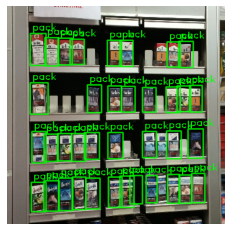

In [ ]:
plt.axis("off")
imshow(cv2.cvtColor(boxed_img, cv2.COLOR_BGR2RGB)/255)

In [ ]:
results_dict = {}
for images, annot in zip(test_set.images, TEST_ANNOTATIONS):
    test_pred_y = sess.run(pred_y, feed_dict={X: [images], is_train: False})
    bboxes = predict_nms_boxes(test_pred_y[0], conf_thres=0.5, iou_thres=0.5)
    bboxes = bboxes[np.nonzero(np.any(bboxes > 0, axis=1))]
    results_dict[annot['filename']] = bboxes.shape[0]

In [ ]:
results_dict

{'/content/ShelfImages/test/C1_P02_N1_S5_1.JPG': 43,
 '/content/ShelfImages/test/C1_P02_N2_S2_1.JPG': 22,
 '/content/ShelfImages/test/C1_P02_N2_S3_1.JPG': 28,
 '/content/ShelfImages/test/C1_P03_N1_S2_1.JPG': 23,
 '/content/ShelfImages/test/C1_P03_N1_S3_1.JPG': 59,
 '/content/ShelfImages/test/C1_P03_N1_S4_1.JPG': 49,
 '/content/ShelfImages/test/C1_P03_N1_S4_2.JPG': 45,
 '/content/ShelfImages/test/C1_P03_N2_S2_1.JPG': 25,
 '/content/ShelfImages/test/C1_P03_N2_S3_1.JPG': 52,
 '/content/ShelfImages/test/C1_P03_N3_S2_1.JPG': 26,
 '/content/ShelfImages/test/C1_P04_N1_S4_1.JPG': 50,
 '/content/ShelfImages/test/C1_P04_N3_S3_1.JPG': 40,
 '/content/ShelfImages/test/C1_P05_N2_S4_2.JPG': 41,
 '/content/ShelfImages/test/C1_P05_N4_S3_1.JPG': 36,
 '/content/ShelfImages/test/C1_P06_N1_S3_1.JPG': 33,
 '/content/ShelfImages/test/C1_P06_N1_S4_1.JPG': 45,
 '/content/ShelfImages/test/C1_P06_N1_S5_1.JPG': 50,
 '/content/ShelfImages/test/C1_P06_N3_S3_1.JPG': 36,
 '/content/ShelfImages/test/C1_P08_N2_S4_1.JPG

In [ ]:
metrics = {
    "mAP" : mAP,
    "precision": precision
}

In [ ]:
with open("metrics.json", "w") as f:
    json.dump(metrics, f)

In [ ]:
with open("results.json", "w") as f:
    json.dump(results_dict, f)

In [ ]:
print("metrics:",metrics)

metrics: {'mAP': 0.8403157894736841, 'precision': 0.8038610038610039}
